In [83]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer # for one-hot encoding, matrix representation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

%pip install pyarrow

In [63]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               48326 non-null  int32         
 1   lpep_pickup_datetime   48326 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  48326 non-null  datetime64[ns]
 3   store_and_fwd_flag     46490 non-null  object        
 4   RatecodeID             46490 non-null  float64       
 5   PULocationID           48326 non-null  int32         
 6   DOLocationID           48326 non-null  int32         
 7   passenger_count        46490 non-null  float64       
 8   trip_distance          48326 non-null  float64       
 9   fare_amount            48326 non-null  float64       
 10  extra                  48326 non-null  float64       
 11  mta_tax                48326 non-null  float64       
 12  tip_amount             48326 non-null  float64       
 13  t

In [65]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime #add duration column
df['duration'] = df.duration.dt.total_seconds() / 60 #convert to minutes
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0,14.183333
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0,5.883333
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0,15.466667
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0,36.083333


In [66]:
df_trip2 = df[df.trip_type == 2] #trip type: dispatch
df_trip2.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,0.0,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667
11,2,2025-01-01 00:18:31,2025-01-01 00:18:46,N,5.0,92,92,1.0,0.00,35.00,...,2.00,0.0,NaN,1.0,38.00,1.0,2.0,0.00,0.0,0.250000
15,2,2025-01-01 00:31:59,2025-01-01 00:32:02,N,5.0,66,66,0.0,0.03,76.00,...,15.40,0.0,NaN,1.0,92.40,1.0,2.0,0.00,0.0,0.050000
18,2,2025-01-01 00:20:31,2025-01-01 00:20:34,N,5.0,197,197,1.0,0.00,13.00,...,1.00,0.0,NaN,1.0,15.00,1.0,2.0,0.00,0.0,0.050000
28,2,2025-01-01 00:48:38,2025-01-01 01:33:50,N,5.0,33,220,2.0,17.07,87.00,...,18.15,0.0,NaN,1.0,108.90,1.0,2.0,2.75,0.0,45.200000


In [67]:
df_trip2.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    1803.000000
mean       15.896349
std        89.490679
min         0.000000
50%         1.300000
95%        38.536667
98%        59.386000
99%       106.789667
max      1439.650000
Name: duration, dtype: float64

In [68]:
((df_trip2.duration >= 1) & (df_trip2.duration <= 60)).mean() #proportion of trips of dispatch between 1 and 60 minutes 

0.4963948973932335

In [69]:
df = df[(df.duration >= 1) & (df.duration <= 60)]
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0,14.183333
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0,5.883333
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0,15.466667
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0,36.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48321,2,2025-01-31 19:36:00,2025-01-31 20:05:00,None,NaN,179,132,NaN,13.99,55.61,...,11.42,0.00,NaN,1.0,68.53,NaN,NaN,NaN,NaN,29.000000
48322,2,2025-01-31 20:33:00,2025-01-31 20:41:00,None,NaN,166,75,NaN,1.51,13.58,...,2.26,0.00,NaN,1.0,17.34,NaN,NaN,NaN,NaN,8.000000
48323,2,2025-01-31 21:09:00,2025-01-31 21:30:00,None,NaN,41,42,NaN,2.90,30.89,...,0.00,0.00,NaN,1.0,32.39,NaN,NaN,NaN,NaN,21.000000
48324,2,2025-01-31 22:22:00,2025-01-31 22:25:00,None,NaN,75,43,NaN,0.34,14.78,...,2.44,0.00,NaN,1.0,18.72,NaN,NaN,NaN,NaN,3.000000


In [70]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [71]:
df[categorical] = df[categorical].astype(str)

In [72]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

6.671386629767925

<function matplotlib.pyplot.show(close=None, block=None)>

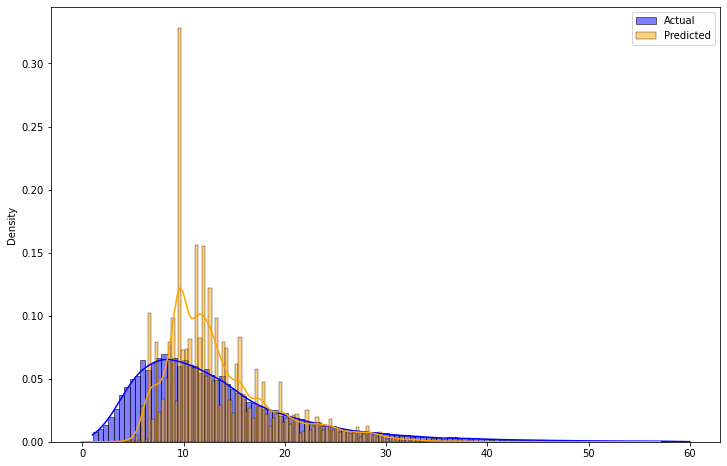

In [73]:
plt.figure(figsize=(12,8))
sns.histplot(y_train, label='Actual', color= 'blue', kde=True, stat='density', alpha=0.5)
sns.histplot(y_pred, label='Predicted', color= 'orange', kde=True, stat='density', alpha=0.5)
plt.legend()
plt.show

In [74]:
mean_squared_error(y_train, y_pred, squared=False)

6.671386629767925

In [75]:
def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime #add duration column
    df['duration'] = df.duration.dt.total_seconds() / 60 #convert to minutes

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [76]:
df_train = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet')
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet')

In [77]:
len(df_train), len(df_val)

(46307, 44218)

In [78]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [79]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [80]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.280256229360907

In [82]:
model = Lasso(alpha=0.01)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.654647415446958

In [84]:
model = Ridge()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.29873518170361